# Multivariate Data Prediction
The data used in this example are taken from four temperature sensors situation on the fore and aft end shields of a CANDU reactor. The data is again indexed on the integers and was read from the field every two seconds.  The application demonstrates the predictive capabilities of the __trcrpm__ in a multivariate setting.

The data is read on a two second interval, and indexed  0,..,𝑛  as required by trcrpm.

The ~2000 samples on each sensor are normal/expected. 

The majority of this file is taken from the trcrpm tutorials. It is included to demonstrate the basic functionality of the code base, as well as to highlight intuitively, the trcrpm algorithm.

In [28]:
# Import the required python libraries imported
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from trcrpm import TRCRP_Mixture

# Indicates to jupyer how the plots are to be displayed and sized
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

In [33]:
# Read and inspect data
data = pd.read_csv("../data/grp2.csv", index_col=0)
data.columns
data.head()

,group_2.0,group_2.1,group_2.2,group_2.3
0,62.224842,61.827423,62.578228,62.666590
1,62.224842,61.827423,62.578228,62.666590
2,61.981956,61.959880,62.777058,62.578228
3,62.048195,61.783270,62.511960,62.136513
4,62.180680,61.893650,62.578228,62.445694


In [15]:
# Split the data into training and helf back
held_back = 100
data_train = data.iloc[0:held_back, :]
data_validate = data.iloc[held_back:-1, :]

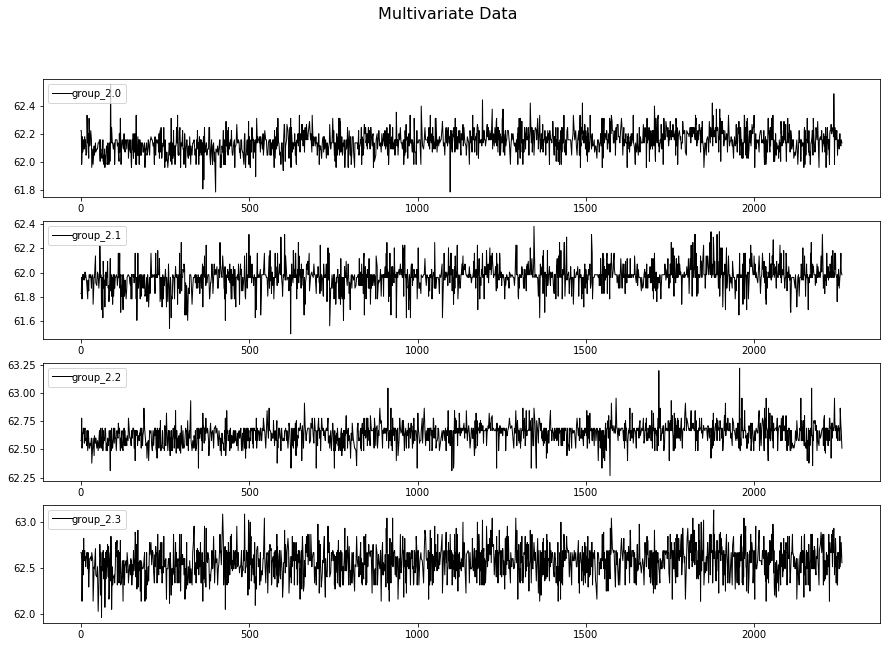

In [34]:
# Plot the data
fig, axes = plt.subplots(nrows=len(data.columns))
fig.suptitle('Multivariate Data', fontsize=16)
for ax, variable in zip(axes, data.columns):
    index = list(data.columns).index(variable)
    x_observed = data.index
    y_observed = data.loc[:,variable]
    ax.plot(x_observed, y_observed, label=variable, color='k', linewidth=1)
    ax.legend(loc='upper left', handletextpad=0)

In [21]:
# Provide entropy ~ number of time series
rng = np.random.RandomState(4)
# Create TRCRP_Mixture model object, with 8 MCMC chaine, and a time dependency over the previous 200 samples
model = TRCRP_Mixture(chains=8, lag=200, variables=data_train.columns, rng=rng)
# Incorporate the data set into the model
model.incorporate(data_train)
# Run MCMC inference the latent state for #steps full Gibbs sweeps through all kernels
model.resample_all(steps=500)
# Run empirical Bayes on variable hyperparameters for full Gibbs sweeps through all kernels
model.resample_hyperparameters(steps=50);
# Set up an index/grid, and number of samples desire per index/grid point to run a simulation
probes = list(data_validate.index[:50])
numsamples = 500
samples = model.simulate(probes, model.variables, numsamples)

In [25]:
# Helper function to plot model predictions from the posterior
def plot_predictions(simulations, variable, ax, states_from_chain=None):
    index = model.variables.index(variable)
    # Plot the observed data.
    x_observed = list(model.dataset.index)
    y_observed = list(model.dataset.loc[:,variable])
    ax.plot(x_observed, y_observed, color='k', linewidth=1)
    ax.set_title('Forecasted Data for %s' % (variable,))
    # Plot 5--95confidence bands around the simulated data. 
    samples = simulations[:,:,index]
    median = np.median(samples, axis=0)
    ax.plot([x_observed[-1], probes[0]], [y_observed[-1], median[0]],
        color='k')
    ax.plot(probes, median, color='k', label='Mean Forecast')
    ax.fill_between(
        probes,
        np.percentile(samples, 5, axis=0),
        np.percentile(samples, 95, axis=0),
        color='gray',
        alpha=0.5)
    #  Plot the held-out data.
    ax.scatter(probes, data_validate.loc[probes,variable],
        color='r', marker='x', label='Held-out Data')
    # Add the legend.
    ax.legend(loc='upper left', handletextpad=0)
    

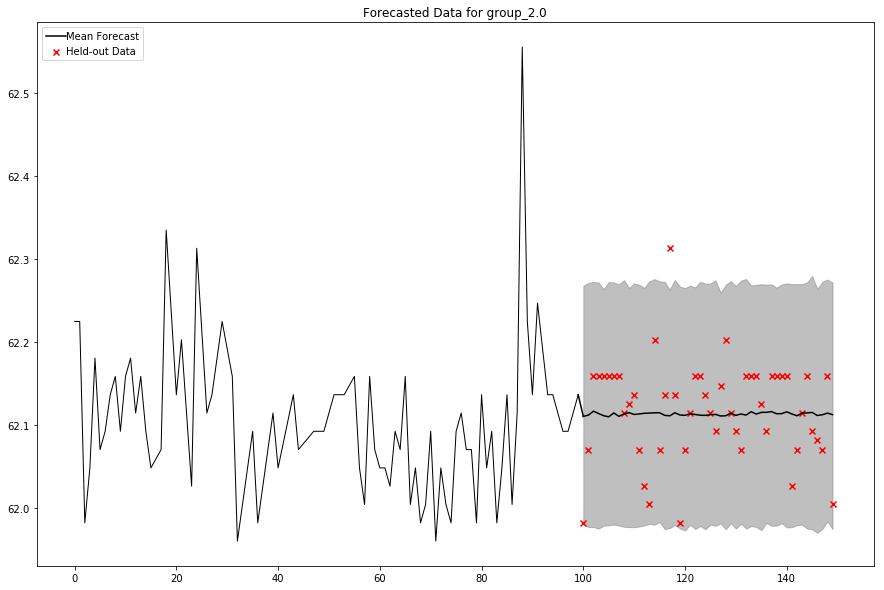

In [29]:
# Plot the predicitions
fig, ax = plt.subplots()
plot_predictions(samples, 'group_2.0', ax)

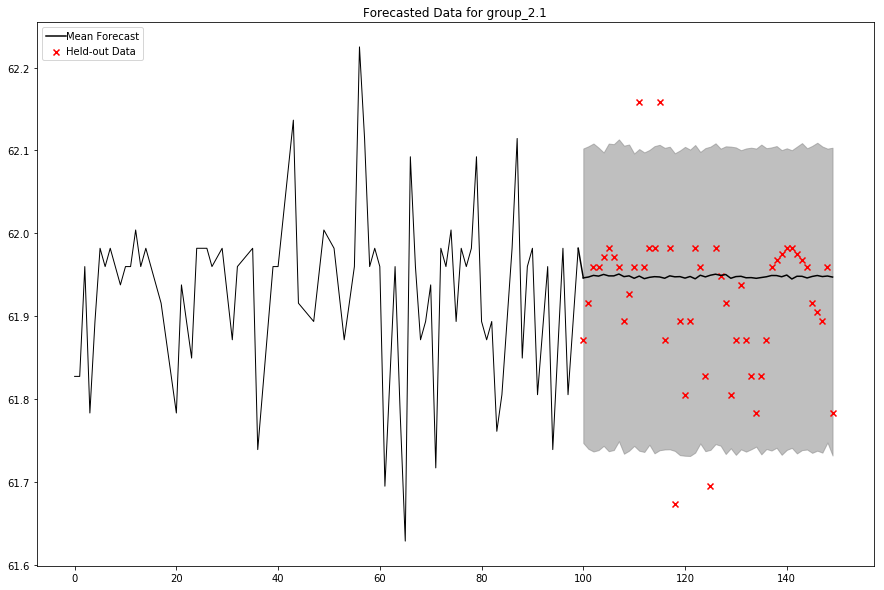

In [30]:
# Plot the predicitions
fig, ax = plt.subplots()
plot_predictions(samples, 'group_2.1', ax)

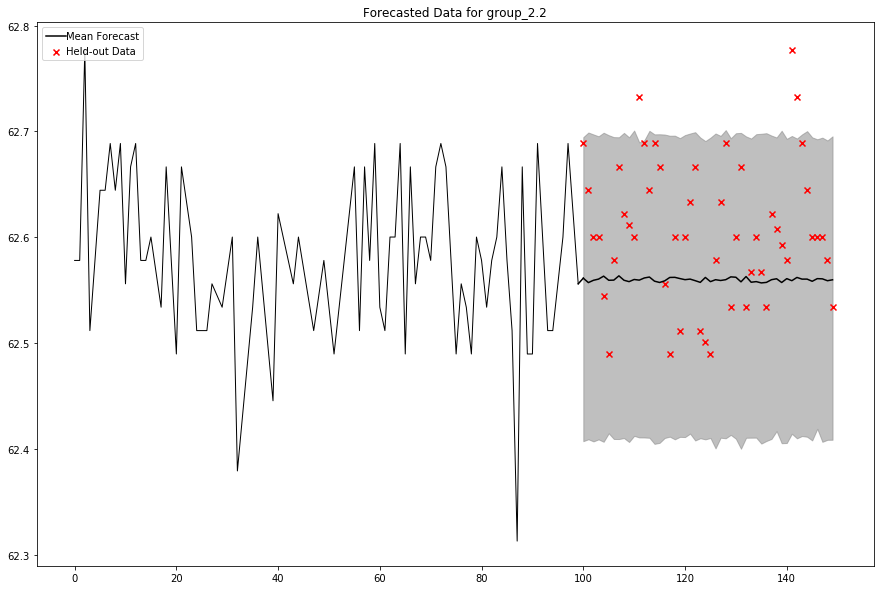

In [31]:
# Plot the predicitions
fig, ax = plt.subplots()
plot_predictions(samples, 'group_2.2', ax)

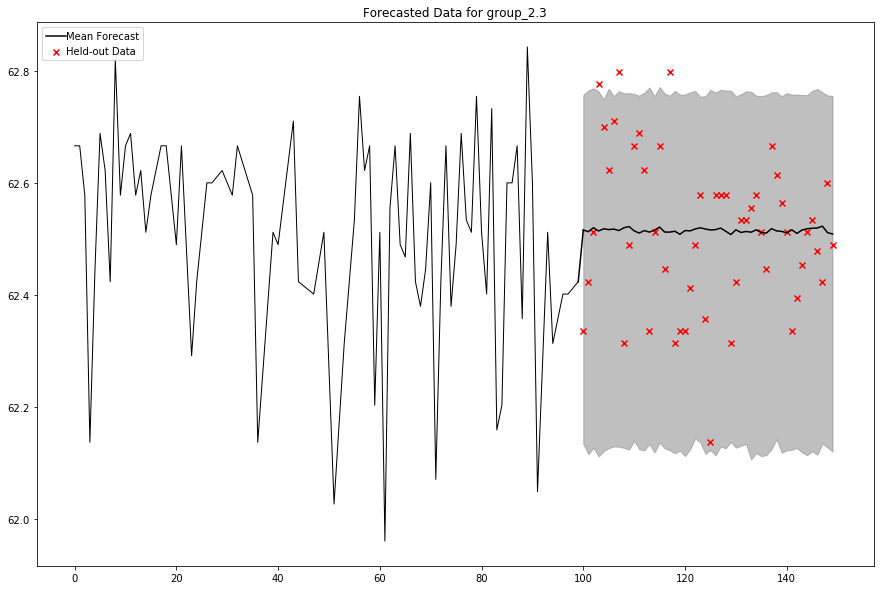

In [32]:
# Plot the predicitions
fig, ax = plt.subplots()
plot_predictions(samples, 'group_2.3', ax)